# SPAM EMAIL DETECTION

Name- Soham Sengupta

Email- sohamsengupta44@gmail.com

In [1]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install keras

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import pickle
from tqdm import tqdm
import nltk
import warnings
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings('ignore')

# Loading Data

In [4]:
completeSpamAssassin = pd.read_csv("completeSpamAssassin.csv", index_col=0)
completeSpamAssassin.head()

,Body,Label
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,##############################################...,1
4,I thought you might like these:\n1) Slim Down ...,1


In [5]:
enronSpamSubset = pd.read_csv("enronSpamSubset.csv", index_col=0)
enronSpamSubset.drop(["Unnamed: 0"], axis=1, inplace=True)
enronSpamSubset = enronSpamSubset.reset_index().drop(['index'], axis = 1)
enronSpamSubset.head()

,Body,Label
0,Subject: stock promo mover : cwtd\n * * * urge...,1
1,Subject: are you listed in major search engine...,1
2,"Subject: important information thu , 30 jun 20...",1
3,Subject: = ? utf - 8 ? q ? bask your life with...,1
4,"Subject: "" bidstogo "" is places to go , things...",1


In [6]:
lingSpam = pd.read_csv("lingSpam.csv", index_col=0)
lingSpam.head()

,Body,Label
0,Subject: great part-time or summer job !\n \n ...,1
1,Subject: auto insurance rates too high ?\n \n ...,1
2,Subject: do want the best and economical hunti...,1
3,Subject: email 57 million people for $ 99\n \n...,1
4,Subject: do n't miss these !\n \n attention ! ...,1


In [7]:
df = pd.concat([completeSpamAssassin, enronSpamSubset, lingSpam], axis=0, ignore_index=True)
df.head()

,Body,Label
0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,##############################################...,1
4,I thought you might like these:\n1) Slim Down ...,1


In [26]:
df.groupby('Label').count()

,Body
Label,
0,11322
1,7329


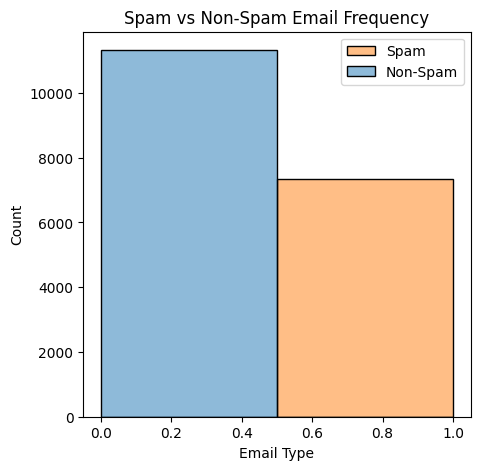

In [27]:
# Plotting Spam vs Non-Spam 
plt.figure(figsize = (5,5))
sns.histplot(data = df, x = 'Label', hue='Label', bins = 2)
plt.xlabel("Email Type")
plt.title("Spam vs Non-Spam Email Frequency")
plt.legend(["Spam","Non-Spam"])
plt.show()

# Pre-processing the document

In [9]:
# lowercase, punctuation, removing numbers and special characters
df.Body = df.Body.str.replace('\d', '')
df.Body = df.Body.astype(str).map(lambda x:re.sub('\W+',' ', x))
df.Body = df.Body.map(lambda x:x.lower())
df.Body = df.Body.map(lambda x:x.translate(str.maketrans('', '', string.punctuation)))

In [10]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
# removing stopwords such as prepositions
stopwords = stopwords.words('english')
df.Body = df.Body.map(lambda x: " ".join(_ for _ in x.split() if _ not in stopwords))

In [12]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [13]:
# lemmatizing the words
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()
df.Body = df.Body.map(lambda x: " ".join(lemmatizer.lemmatize(_) for _ in x.split()))

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [14]:
df.head()

,Body,Label
0,save life insurance spend life quote saving en...,1
1,fight risk cancer http www adclick w p cfm pk ...,1
2,fight risk cancer http www adclick w p cfm pk ...,1
3,adult club offer free membership instant acces...,1
4,thought might like slim guaranteed lose lb day...,1


# Splitting into Train Test

In [15]:
# Spliting the test train in 20% 80% ratio
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['Body'], df['Label'], test_size =0.2, random_state=41)


print('Number of rows in the total set: {}'.format(df.shape[0]))
print('Number of rows in the training set: {}'.format(X_train.shape[0]))
print('Number of rows in the test set: {}'.format(X_test.shape[0]))

Number of rows in the total set: 18651
Number of rows in the training set: 14920
Number of rows in the test set: 3731


# Frequency Distribution

In [16]:
# import pandas as pd
# from sklearn.feature_extraction.text import CountVectorizer

# # Initialize the CountVectorizer
# count_vector = CountVectorizer()

# # Split your training and testing data into batches
# batch_size = 500  # You can adjust this batch size as needed
# num_train_samples = len(X_train)
# num_test_samples = len(X_test)

# # Create an empty DataFrame to store the frequency matrix
# frequency_matrix_train = pd.DataFrame()

# # Process training data in batches
# for i in tqdm(range(0, num_train_samples, batch_size)):
#     batch_X_train = X_train[i:i+batch_size]
#     batch_training_data = count_vector.fit_transform(batch_X_train)
    
#     # Convert the batch training data to a DataFrame and append to the main training frequency matrix
#     batch_frequency_matrix_train = pd.DataFrame(batch_training_data.toarray(), columns=count_vector.get_feature_names_out())
#     frequency_matrix_train = pd.concat([frequency_matrix_train, batch_frequency_matrix_train], ignore_index=True)

# # Create an empty DataFrame to store the testing frequency matrix
# frequency_matrix_test = pd.DataFrame()

# # Process testing data in batches
# for i in tqdm(range(0, num_test_samples, batch_size)):
#     batch_X_test = X_test[i:i+batch_size]
#     batch_testing_data = count_vector.transform(batch_X_test)
    
#     # Convert the batch testing data to a DataFrame and append to the main testing frequency matrix
#     batch_frequency_matrix_test = pd.DataFrame(batch_testing_data.toarray(), columns=count_vector.get_feature_names_out())
#     frequency_matrix_test = pd.concat([frequency_matrix_test, batch_frequency_matrix_test], ignore_index=True)

# # Now, you have the training and testing frequency matrices in frequency_matrix_train and frequency_matrix_test.


The above method using CounterVectorizer() uses too much RAM and having problem with Memory Error, instead we use TfidfVectorizer. The TF-IDF vectorization tends to create less dense matrices, which can save memory.

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training data
training_data = tfidf_vectorizer.fit_transform(X_train)

# Transform the testing data
testing_data = tfidf_vectorizer.transform(X_test)

# Create a DataFrame with the TF-IDF matrix for training data
tfidf_matrix_train = pd.DataFrame(training_data.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Create a DataFrame with the TF-IDF matrix for testing data
tfidf_matrix_test = pd.DataFrame(testing_data.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Now, you have the TF-IDF matrices for training and testing data in tfidf_matrix_train and tfidf_matrix_test.

In [18]:
tfidf_matrix_train

,aa,aaa,aaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaacuxrmplffhxl,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaacmmvzcjzld,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaacuwlcuwmdlo,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaabcfudhgkxt,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaacuxrmplffhxlmh,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaafcvwyfk,...,ˆì¼,ˆìœµ,ˆìœµê,ˆìœµë,ˆìœµìž,ˆí,ˆï,ˆï¼œå,ˆï¼œå¹,ˆï¼œæ
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14917,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14918,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
#Train the data
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
y_pred = lr.fit(tfidf_matrix_train, y_train).predict(tfidf_matrix_test)

Text(113.9222222222222, 0.5, 'Actual label')

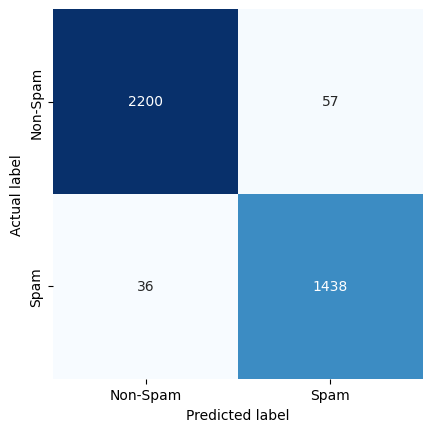

In [28]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_pred)
labels = ['Non-Spam', 'Spam']
 
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)
 
plt.xlabel('Predicted label')
plt.ylabel('Actual label')

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Accuracy score: ', format(accuracy_score(y_test, y_pred)))
print('Precision score: ', format(precision_score(y_test, y_pred)))
print('Recall score: ', format(recall_score(y_test, y_pred)))
print('F1 score: ', format(f1_score(y_test, y_pred)))

Accuracy score:  0.9750737067810239
Precision score:  0.9618729096989966
Recall score:  0.9755766621438263
F1 score:  0.9686763219939374


Accuracy of the model is 97.5% that means the model is very accurate in classifying a mail spam or not. An accuracy of 97.5% means that the model correctly predicted the class labels for approximately 97.5% of the total instances in your dataset.

A precision of 96.18% means that, out of all the spam predictions made by your model, approximately 96.18% of them were correct.

A recall of 97.56% means that your model correctly identified approximately 97.56% of all the actual spam cases in your dataset.

An F1 score of 96.87% indicates that your model achieves a high balance between precision and recall. It's a measure that combines both precision and recall into a single metric, providing a way to assess a model's overall performance in binary classification tasks.

# Logistic Using Balanced Class

In [30]:
#Train the data
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(class_weight='balanced')
y_pred = lr.fit(tfidf_matrix_train, y_train).predict(tfidf_matrix_test)

Text(113.9222222222222, 0.5, 'Actual label')

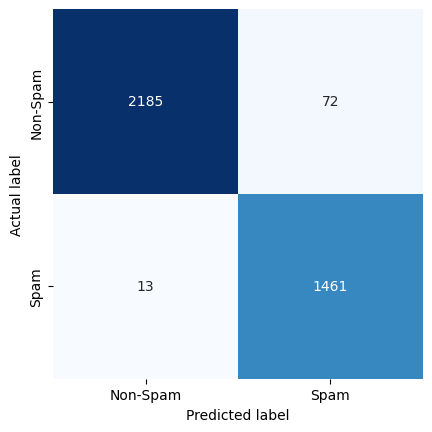

In [31]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_pred)
labels = ['Non-Spam', 'Spam']
 
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)
 
plt.xlabel('Predicted label')
plt.ylabel('Actual label')

In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Accuracy score: ', format(accuracy_score(y_test, y_pred)))
print('Precision score: ', format(precision_score(y_test, y_pred)))
print('Recall score: ', format(recall_score(y_test, y_pred)))
print('F1 score: ', format(f1_score(y_test, y_pred)))

Accuracy score:  0.9772179040471723
Precision score:  0.9530332681017613
Recall score:  0.991180461329715
F1 score:  0.9717326238776189


After Balancing the Classes using Weights...

Accuracy of the model is 97.72% that means the model is very accurate in classifying a mail spam or not. An accuracy of 97.72% means that the model correctly predicted the class labels for approximately 97.5% of the total instances in your dataset.

A precision of 95.3% means that, out of all the spam predictions made by your model, approximately 95.3% of them were correct.

A recall of 99.12% means that your model correctly identified approximately 99.12% of all the actual spam cases in your dataset.

An F1 score of 97.17% indicates that your model achieves a high balance between precision and recall. It's a measure that combines both precision and recall into a single metric, providing a way to assess a model's overall performance in binary classification tasks.

Overall we can see that using balance class provides a slight improvement in the model.

# ROC Curve

In [37]:
y_proba = lr.predict_proba(tfidf_matrix_test)[:1]

In [38]:
y_proba

array([[0.0376063, 0.9623937]])

In [44]:
pred_prob = list((y_pred))

In [42]:
from sklearn.metrics import roc_curve, roc_auc_score

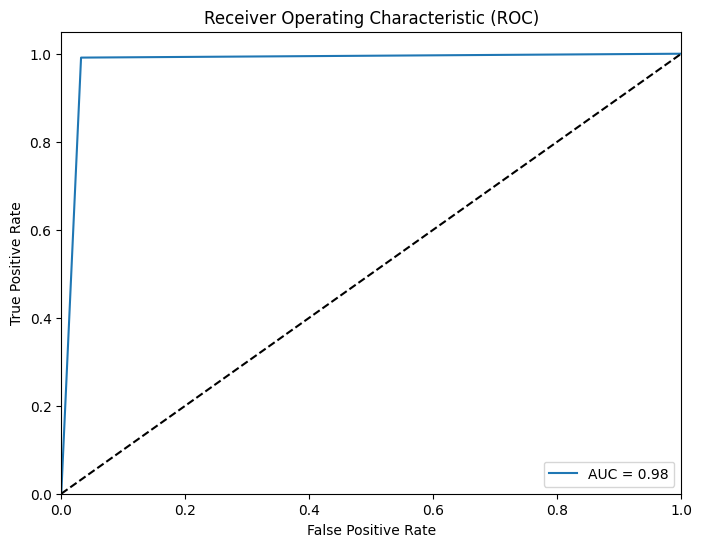

In [45]:
# Calculate ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, pred_prob)
roc_auc = roc_auc_score(y_test, pred_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


The ROC curve shows that AUC Area under the Curve is 98% , Hence the model captures the variabilities very well.